# Relevant imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.legend_handler import HandlerBase
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='stix'
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150
plt.rcParams['axes.facecolor'] = 'white'


Bad key "text.kerning_factor" on line 4 in
/home/maamari/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


---

In [25]:
class VDS0():  

############################# INITIALIZATION #############################
    
    def __init__(self, h = 0.6727, Omega_m = 0.26495, Omega_b = 0.05, Omega_rad = 9.23640e-5, p_crit = 4.755e-6,
                 rho_crit = 4.755e-6, T0 = 2.7255, kb = 8.617333262145e-5, m_p = 0.93827231, nu = 1.12,
                 Y_p = 0.75, n_e = 0.18820, x_e = 1.16371, sigmaT = 6.65246e-29, c = 3e5, Mpc2cm = 3.086e24, 
                 masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]), 
                 sigma_array = np.logspace(-10,-40,200)):
        
        self.h = h
        self.H0 = 100*h
        self.Omega_m = Omega_m
        self.Omega_b = Omega_b
        self.Omega_rad = Omega_rad
        self.Y_p = Y_p
        self.m_p = m_p
        self.nu = nu
        self.n_e = n_e
        self.x_e = x_e
        self.sigmaT = sigmaT
        self.rho_crit = 1.256*10**11*Omega_m
        self.rho_b = Omega_b*p_crit
#         self.T_0 = kb*T0*1e-9
        self.T_0 = 2.353e-13        
        self.Mpc2m = Mpc2cm*1e-2
        self.Rx_conerverionFactor = c*Mpc2cm
        
        self.masses = masses
        self.sigma_array = sigma_array
            
############################# SEMI-ANALYTIC FUNCTIONS #############################
    
    def N_0(self,n):
        return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

    def mhm2khm(self,Mhm):
        return np.pi/self.h*(((4.*np.pi*self.rho_crit)/(3*Mhm))**(1./3.))
        
    def Rx(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow(((self.T_0*(1+z))/(m_x))+((self.T_0*(1+z))/self.m_p),((1.+n)/2.)))

    def Rx_noZ(self,sigma_0, m_x, n):
        return self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0/m_x)+(self.T_0/self.m_p),((1.+n)/2.)))
    
    def Rx_kin(self,z,sigma_0,m_x,n):
        return (pow(z,2) * ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.))*(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p)))

    def Rx_th(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0*z)/(m_x)+((self.T_0*z)/self.m_p),((1.+n)/2.)))
    
    def Rgamma(self,z):
        return pow(z,2)*self.n_e*self.x_e*self.sigmaT*self.Mpc2m
    
    def aH(self,z,sigma_0,m_x,n):
        return z*(self.H0*np.sqrt(self.Omega_rad))

    def z_th(self,sigma_0,m_x,n):
        return ((self.H0*np.sqrt(self.Omega_rad)*(m_x+self.m_p))/(self.Rx_noZ(sigma_0,m_x,n)*m_x))**(2./(n+3.))

    def z_kin(self,sigma_0,m_x,n):
        return fsolve(lambda z: z * ((self.T_0*z**2)/((1+self.z_th(sigma_0,m_x,n))*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.) - (self.H0*np.sqrt(self.Omega_rad)/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    
    
    def z_gamma(self,sigma_0,m_x,n):
        return fsolve(lambda z: ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*self.z_th(sigma_0,m_x,n))/self.m_p)**((n+1.)/2.) - (self.n_e*self.x_e*self.sigmaT*self.Mpc2m/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    

    def sigma2k(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_kin(sigma_0,m_x,n))*3.33e-6
    
    def sigma2k2(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_gamma(sigma_0,m_x,n))*3.33e-6

    def sig(self,klimit,n):
        sigma = []
        for i in range(len(self.masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k(self.sigma_array,self.masses[i],n)-self.h*klimit))])
        return np.array(sigma)

    def sig2(self,klimit,n):
        sigma = []
        for i in range(len(self.masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k2(self.sigma_array,self.masses[i],n)-self.h*klimit))])
        return np.array(sigma)
    
    def sigma_vs_mx(self,klimit,n):
        return hv.Curve((masses, self.sig(klimit,n)))
    
############################# INI GENERATION #############################

    def make_inis(self,ini_base_file='class/inis/dmeff_base.ini',base_inis_path='class/inis/',class_runner_path = 'class/',npow=0,
                  masses=np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]),sigmas=np.logspace(-20,-30,100),output_path='pk_output',
                  sh_file='class/run_classes.sh'):
    
        fin =  open(ini_base_file, 'r')
        base_content = fin.read()
        fin.close()
        fout_sh = open(class_runner_path+'run_classes.sh', 'w')

        for m in masses:
            for sigma in sigmas:
                filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
                fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
                fout = open(base_inis_path + filename, 'w')
                fout.write(base_content)
                fout.write('\n')
                npow_line = 'npow_dmeff = {}\n'.format(npow)
                fout.write(npow_line)
                m_line = 'm_dmeff = {}\n'.format(m)
                fout.write(m_line)
                sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
                fout.write(sigma_line)
                if npow<0:
                    vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                    fout.write(vel_line)
                root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
                fout.write(root_line)

        fout_sh.close()

############################# TK PLOTTING FUNCTIONS #############################
        
    def single_tk(self,approach='numerical',npow=0,m=0.0001,plotPeaks=False,pltType='none',
                  index=0,sigmas=np.logspace(-20,-30,100),lw=2.5,label='',
                  c='k',ls='-',alpha=1):
        if approach=='numerical':
            data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        elif approach=='analytic':
            data0 = np.loadtxt('class/pk_output/lcdm_z1_pk_anal.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            # Index of interest
            if i!=index:
                continue
            print(sigma)
            
            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)   
            print(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]
            ax.plot(ks,pk/pk0,linewidth=lw,linestyle=ls,color=c,label=label,alpha=alpha)

        return (pk)/pk0,ks,sigma
    
    def all_sigmas(self,npow=0,m=0.0001,sigmas=np.logspace(-20,-30,100),
               z='z1',colorbar=False,pk_root='class/pk_output/',
               filename=None,label='',lw=0.3,lowlim=0,uplim=100,c='r'):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#D81B60','tan','#63acbe'])
        cm2 = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
        
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            if i>=uplim or i<lowlim or i==len(sigmas)-1 or i%5!=0:
                continue
                
            # colors/labels for peak plot
            lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{ cm}^2$"
            c=cm(int(i*4.))

            try:                                    
                # pk data from class for given mass, sigma, power
                filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
                data = np.loadtxt(filename)
                pk = data[:,1]
                ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,alpha=1.) 
                sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm2,s=0.001,alpha=0.7)
            except: continue

#         if colorbar:
#             tick_locs = [1e-30,1e-20]
#             tick_labels = ["$\sigma_0 = 10^{-30}$ cm$^2$","$\sigma_0 = 10^{-20}$ cm$^2$"]
#             cb = plt.colorbar(sc, orientation="vertical")
#             cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
#             cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
#             cb.update_ticks()
#             cb.ax.tick_params(labelsize=33,length=15,width=3,color='w')
#             cb.ax.locator_params(nbins=2)
           
    def all_masses(self,npow=0,masses=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1],
                   sigma=1e-20,z='z1',colorbar=False,pk_root='class/pk_output/',
                   filename=None,label='',lw=0.3):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
    
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,m in enumerate(masses):
            lbl = "$\mass=$"+str('{:.1e}'.format(float(m)))+r"$\textrm{ GeV}$"
            c=cm(int(i*35.))

            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
            data = np.loadtxt(filename)
            pk = data[:,1]

            ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,label=lbl,alpha=1.) 
            sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm,s=0.001,alpha=0.7)
                
        if colorbar:
            tick_locs = [1e-30,1e-20]
            tick_labels = ["$m = 10^{-5}$ GeV","$m = 10$ GeV"]
            cb = plt.colorbar(sc, orientation="vertical")
            cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
            cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
            cb.update_ticks()
            cb.ax.tick_params(labelsize=33,length=15,width=3,color='w')
            cb.ax.locator_params(nbins=2)
            
    def transfer(self,k,mwdm):
        lambda_fs = (0.049*(mwdm**(-1.11))*((self.Omega_m/0.25)**(0.11))*((self.h/0.7)**1.22))
        alpha = lambda_fs
        transfer = (1+(alpha*k)**(2*self.nu))**(-5./self.nu)
        return transfer

In [26]:
vds0 = VDS0()

---

In [27]:
masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
n0n2sigs = np.logspace(-20,-30,50)
n4sigs_m0001 = np.logspace(-20,-27,50)
n4sigs_m01 = np.logspace(-15,-20,50)
n4sigs_m1 = np.logspace(-15,-20,20)
n6sigs_m0001 = np.logspace(-20,-25,20)
n6sigs_m01 = np.logspace(-12,-15,20)
n6sigs_m1 = np.logspace(-7,-10,20)
klim = vds0.mhm2khm(3.2*10**8)
kcmb = vds0.mhm2khm(1e14)

## Figure 2

3.0721129988617717e-23
class/pk_output/n2_m1_s3.0721129988617717e-23_z1_pk.dat
1.4481182276745359e-18
class/pk_output/n4_m1_s1.4481182276745359e-18_z1_pk.dat


/home/maamari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in power


4.8241087041653735e-14
class/pk_output/n6_m1_s4.8241087041653735e-14_z1_pk.dat


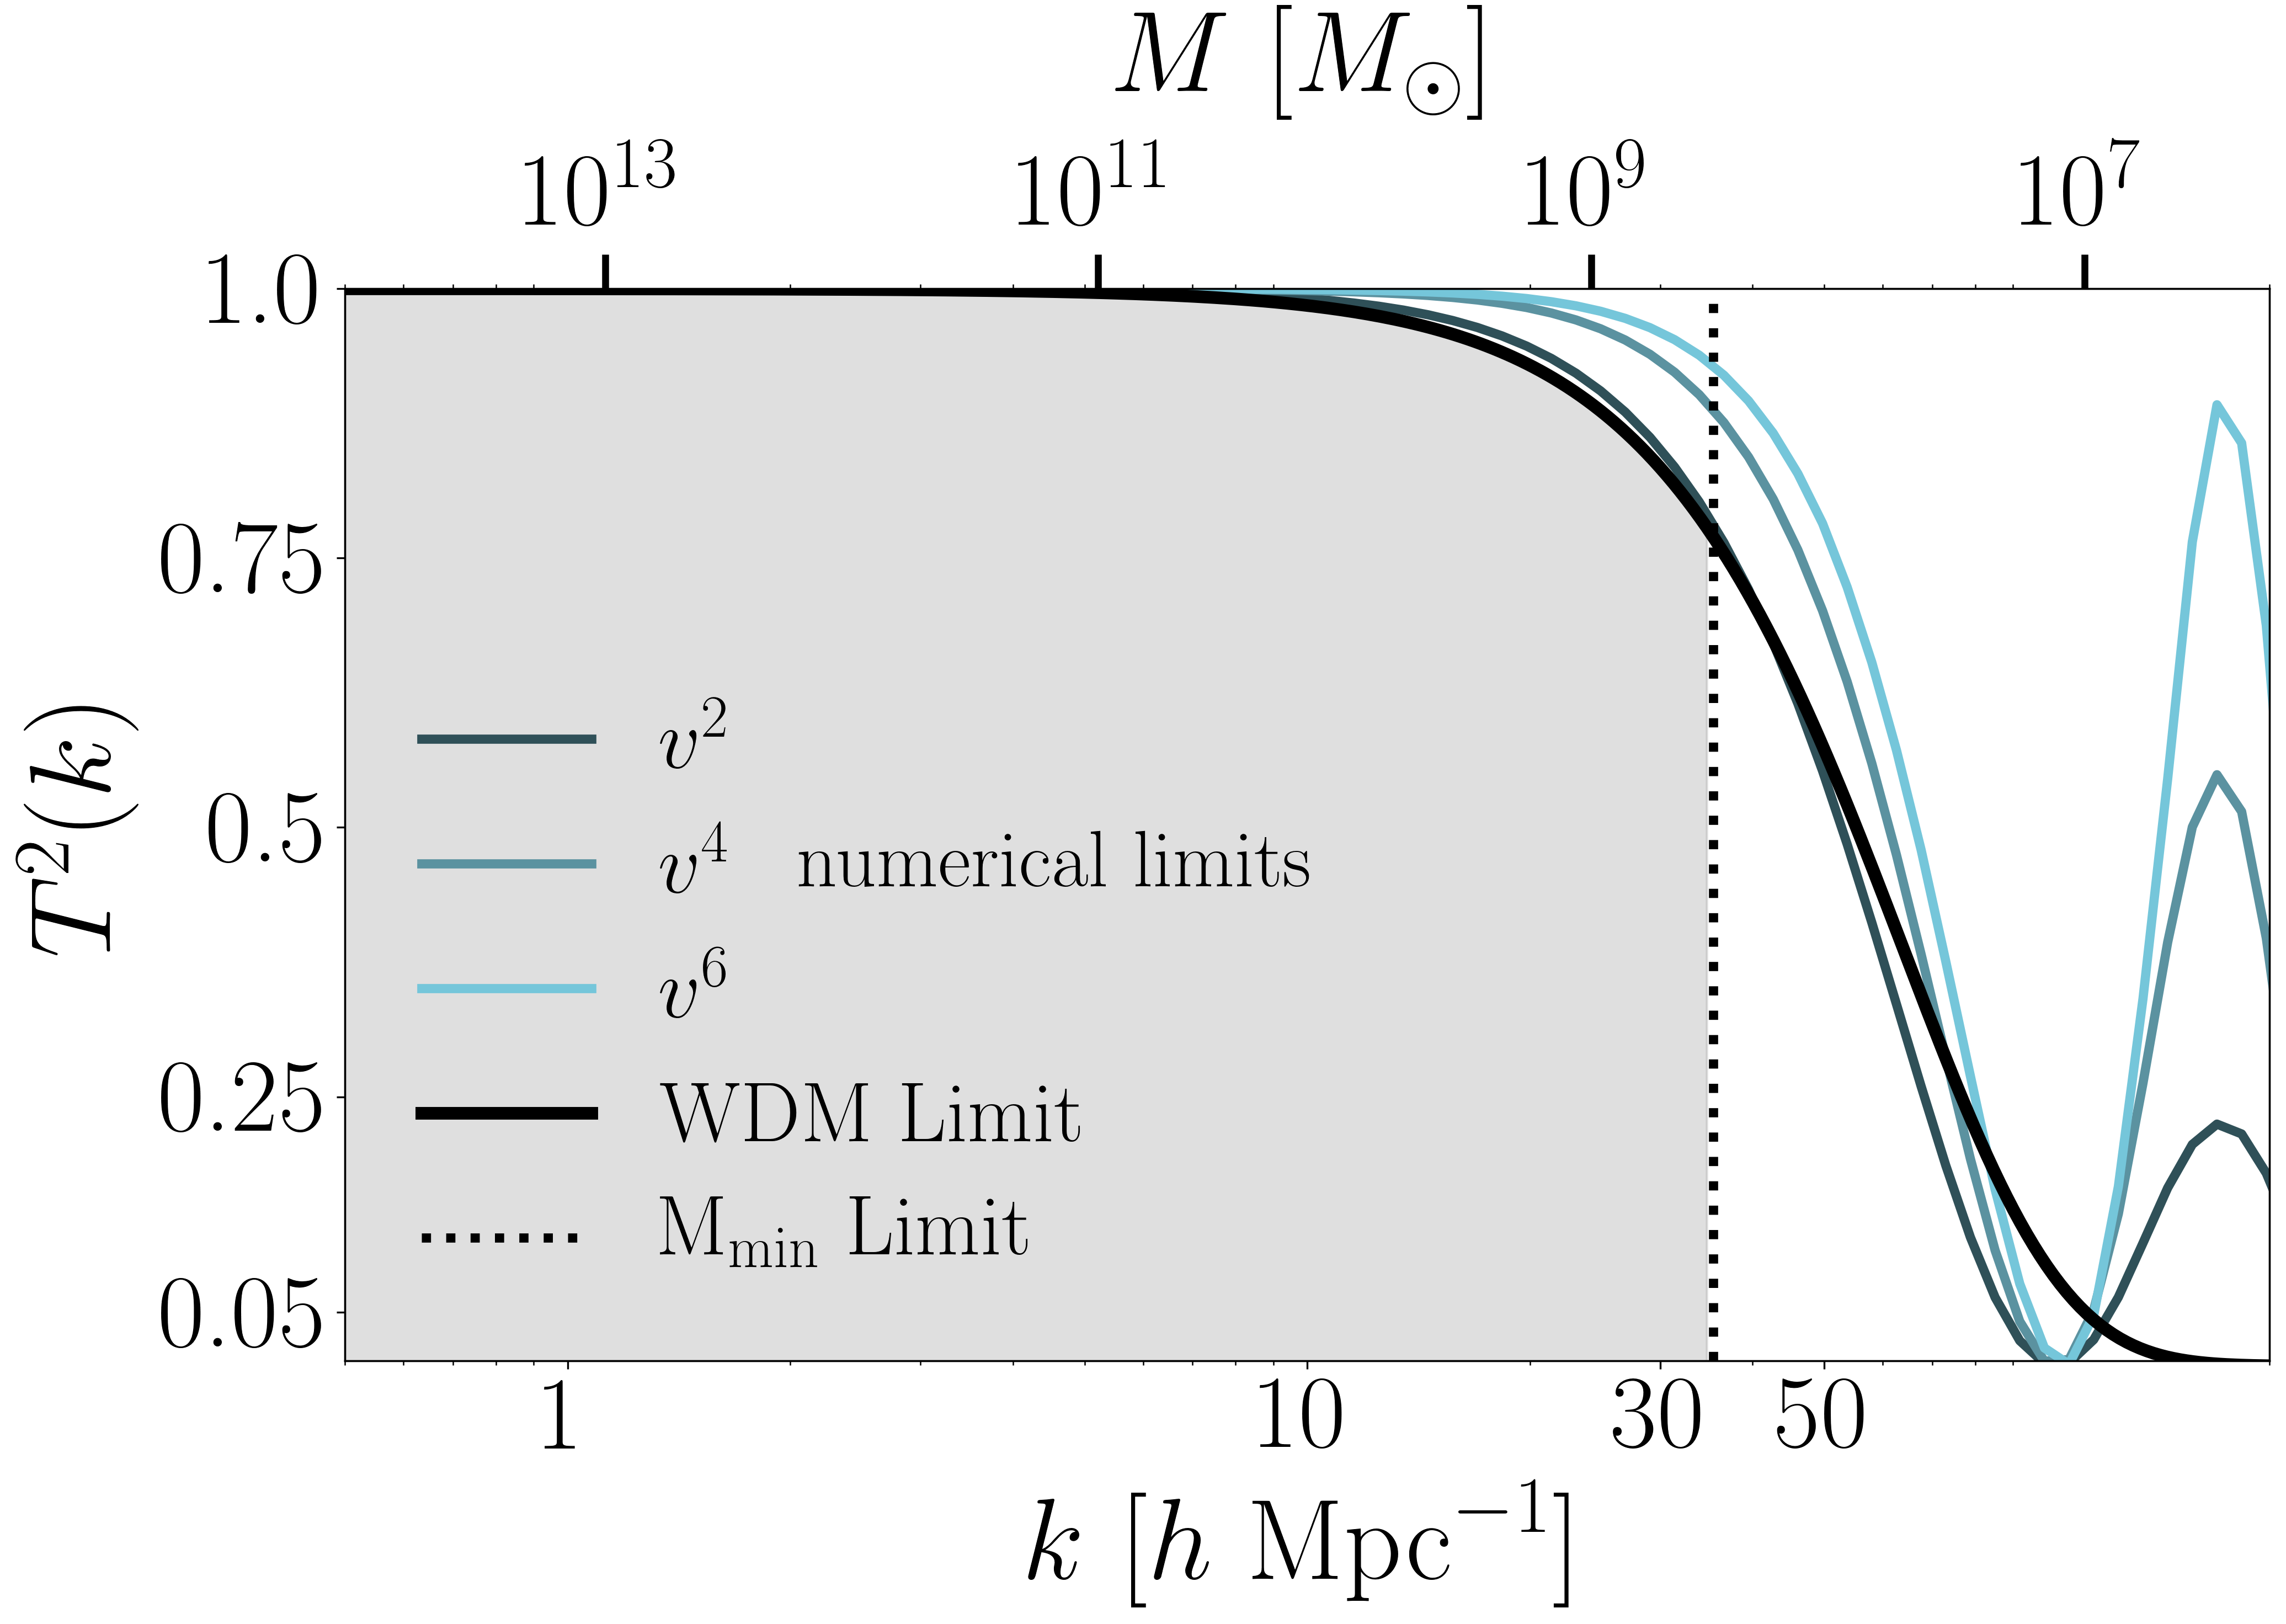

In [29]:
fig = plt.figure(figsize=(14,10))    
ax = fig.add_subplot(111)
ax2 = ax.twiny()

######## n=2, m=1 GeV ########
tk_idm_c,ks,sigma0 = vds0.single_tk(approach='numerical',npow=2,m=1,c='#ED578D',label=r'$v^2$',sigmas=n0n2sigs,index=4,lw=4)
# tk_idm_a,ks,sigma0 = vds0.single_tk(approach='analytic',npow=2,m=1,c='#2F5058',label=r'$v^2$',sigmas=[vds0.sig(klim,2.)[4]],index=0,lw=4)

######## n=4, m=1 GeV ########
tk_idm_c,ks,sigma0 = vds0.single_tk(approach='numerical',npow=4,m=1,c='#D81B60',label=r'$v^4$',sigmas=n4sigs_m1,index=1,lw=4)
# tk_idm_a,ks,sigma0 = vds0.single_tk(approach='analytic',npow=4,m=1,c='#5B92A0',label=r'$v^4$',sigmas=[vds0.sig(klim,4.)[4]],index=0,lw=4)

######## n=6, m=1 GeV ########
tk_idm_c,ks,sigma0 = vds0.single_tk(approach='numerical',npow=6,m=1,c='#7E1038',label=r'$v^6$',sigmas=n6sigs_m1,index=17,lw=4)
# tk_idm_a,ks,sigma0 = vds0.single_tk(approach='analytic',npow=6,m=1,c='#75C6DA',label=r'$v^6$',sigmas=[vds0.sig(klim,6.)[4]],index=0,lw=4)

############################################### WDM/Mmin Limits #########################################################
ks2 = np.logspace(-5,4,1000)
ax.semilogx(ks2,vds0.transfer(ks2,6.5)**2,linestyle='-',label='WDM Limit',c='k',lw=5.5)
ax.axvline(klim,c='k',ls=':',lw=4,label=r'M$_{\rm{min}}$ Limit')
ax.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,6.5)**2,where=np.logspace(-5,4,1000)<klim,color='grey',alpha=0.25)

################################################# PLOT OPTIONS #####################################################
ax.set_xscale('log')
ax.set_xlim(0.5,200)
ax.set_ylim(0.005,1.)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T^2(k)$',fontsize=50,labelpad=10)
ax.set_xticks([1,10,30,50])
ax.set_xticklabels(["1","10","30","50"],fontsize=45)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)
ax.legend(fontsize=37,framealpha=0,loc='lower left')
ax2.text(2.05, 0.445, "numerical limits",size=35)
ax2.set_xscale('log')
ax2.set_xlim(0.5,200)
ax2.set_xticks([vds0.mhm2khm(10**13),vds0.mhm2khm(10**11),vds0.mhm2khm(10**9),vds0.mhm2khm(10**7)])
ax2.set_xticklabels([r'10$^{13}$',r'10$^{11}$',r'10$^{9}$',r'10$^{7}$'],fontsize=45)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=50,labelpad=20)
ax2.tick_params(length=15,width=3)

plt.tight_layout()
plt.savefig("plots/exclusions/fig2_cons.png")

## Figure 3

In [23]:
mass = [0.0001,0.01,1]
mass_eft = [1.5e-5,0.001,1,1000]
mass_eft6 = [1,1000]

In [24]:
# WDM = 6.6
sigs0cons = np.array([6.866488450043026e-29,2.8117686979742367e-28,1.8420699693267164e-27])
sigs2cons = np.array([7.543120063354607e-27,1.389495494373136e-23,1.5264179671752366e-21])
sigs4cons = np.array([1.9306977288832457e-26,2.1209508879201925e-19,5.455594781168515e-16])
sigs6cons = np.array([6.951927961775591e-24,1e-12,2.0691380811147902e-10]) # 0.01 close to passing, 0.0001 grows at end

sigs0_cmb = [vds0.sig(kcmb,0.)[0],vds0.sig(kcmb,0.)[2],vds0.sig(kcmb,0.)[4]]
sigs2_cmb = [vds0.sig(kcmb,2.)[0],vds0.sig(kcmb,2.)[2],vds0.sig(kcmb,2.)[4]]
sigs4_cmb = [vds0.sig(kcmb,4.)[0],vds0.sig(kcmb,4.)[2],vds0.sig(kcmb,4.)[4]]
sigs6_cmb = [vds0.sig(kcmb,6.)[0],vds0.sig(kcmb,6.)[2],vds0.sig(kcmb,6.)[4]]

sigs0_anal = [vds0.sig(klim,0.)[0],vds0.sig(klim,0.)[2],vds0.sig(klim,0.)[4]]
sigs2_anal = [vds0.sig(klim,2.)[0],vds0.sig(klim,2.)[2],vds0.sig(klim,2.)[4]]
sigs4_anal = [vds0.sig(klim,4.)[0],vds0.sig(klim,4.)[2],vds0.sig(klim,4.)[4]]
sigs6_anal = [vds0.sig(klim,6.)[0],vds0.sig(klim,6.)[2],vds0.sig(klim,6.)[4]]

sigs0_eft = np.array([8.8e-27,2.6e-26,1.5e-25,1.4e-23])
sigs2_eft = np.array([4.2e-23,4.3e-21,5.3e-18,2.2e-15])
sigs4_eft = np.array([1.6e-20,1.0e-16,4.1e-11,9.3e-09])
sigs6_eft = np.array([5.0e-04,1.5e+00])

sigs0_eft_ = np.array([1.44e-26,4.67e-26,1.5e-25])
sigs2_eft_ = np.array([3.34e-26,4.75e-20,5.3e-18])
sigs4_eft_ = np.array([7.9e-19,7.45e-15,4.1e-11])

/home/maamari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in power


In [ ]:
plt.figure(figsize=(18,10))

##### n=0 ######
plt.loglog(mass_eft,sigs0_eft,label="CMB",linestyle='-',c='k',lw=7)
plt.loglog(mass,sigs0cons,label="Numerical limit",linestyle='-',c='#D81B60',lw=7)
plt.loglog(mass, sigs0_anal,label="Analytic estimate",lw=7,linestyle='--',c='#63acbe')
plt.fill_between(mass, sigs0_anal, 1, color='grey', alpha=0.3)
plt.fill_between(mass, sigs0cons, 1, color='grey', alpha=0.5)
plt.text(1.4e-4,8e-20,"$n=0$",fontsize=50)
# plt.ylim(1e-32,1e-24)

###### n=2 ######
# plt.loglog(mass_eft,sigs2_eft,label="CMB",linestyle='-',c='k',lw=7)
# plt.loglog(mass,sigs2cons,label="Numerical limit",linestyle='-',c='#D81B60',lw=7)
# plt.loglog(mass, sigs2_anal, label="Analytic estimate",lw=7,linestyle='--',c='#63acbe')
# plt.fill_between(mass, sigs2_anal, 1, color='grey', alpha=0.3)
# plt.fill_between(mass, sigs2cons, 1, color='grey', alpha=0.5)
# plt.text(1.4e-4,1e-30,"$n=2$",fontsize=50)
# plt.text(1.4e-4,8e-20,"$n=2$",fontsize=50)
# plt.yticks([1e-30,1e-27,1e-24,1e-21,1e-18],["$10^{-30}$","$10^{-27}$","$10^{-24}$","$10^{-21}$","$10^{-18}$"])
plt.ylim(1e-31,1e-17)

###### n=4 ######
# plt.loglog(mass_eft,sigs4_eft,label="CMB",linestyle='-',c='k',lw=7)
# plt.loglog(mass,sigs4cons,label="Numerical limit",linestyle='-',c='#D81B60',lw=7)
# plt.loglog(mass, sigs4_anal, label="Analytic estimate",lw=7,linestyle='--',c='#63acbe')
# plt.fill_between(mass, sigs4_anal, 1, color='grey', alpha=0.3)
# plt.fill_between(mass, sigs4cons, 1, color='grey', alpha=0.5)
# plt.text(1.4e-4,4e-13,"$n=4$",fontsize=50)
# plt.text(1.4e-4,0.8e-31,"$n=4$",fontsize=50)
# plt.yticks([1e-31,1e-26,1e-21,1e-16,1e-11],["$10^{-31}$","$10^{-26}$","$10^{-21}$","$10^{-16}$","$10^{-11}$"])
# plt.ylim(1e-33,1e-9)

###### n=6 ######
# plt.loglog(mass,sigs6cons,label="Numerical limit",linestyle='-',c='#D81B60',lw=7)
# plt.loglog(mass, sigs6_anal, label="Analytic estimate",lw=7,linestyle='--',c='#63acbe')
# plt.fill_between(mass, sigs6_anal, 1, color='grey', alpha=0.3)
# plt.fill_between(mass, sigs6cons, 1, color='grey', alpha=0.5)
# plt.text(1.4e-4,4e-12,"$n=6$",fontsize=50)
# plt.text(1.4e-4,2e-27,"$n=6$",fontsize=50)
# plt.ylim(1e-28,1e-7)

plt.xlim(1e-4,1e0)
# plt.ylim(1e-30,1e-9)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]",fontsize=55,labelpad=5)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]",fontsize=55,labelpad=20)
plt.legend(fontsize=40,loc='upper right',framealpha=0)
plt.tick_params(labelsize=45,length=10,width=2)
plt.tick_params(which='minor',length=5,width=1.5)

plt.tight_layout()
plt.savefig("plots/limits/limits_n0_CAE.png")
# plt.savefig("plots/limits/limits_n2_CAE.png")
# plt.savefig("plots/limits/limits_n4_CAE.png")
# plt.savefig("plots/limits/limits_n6_CA.png")

## Figure 1

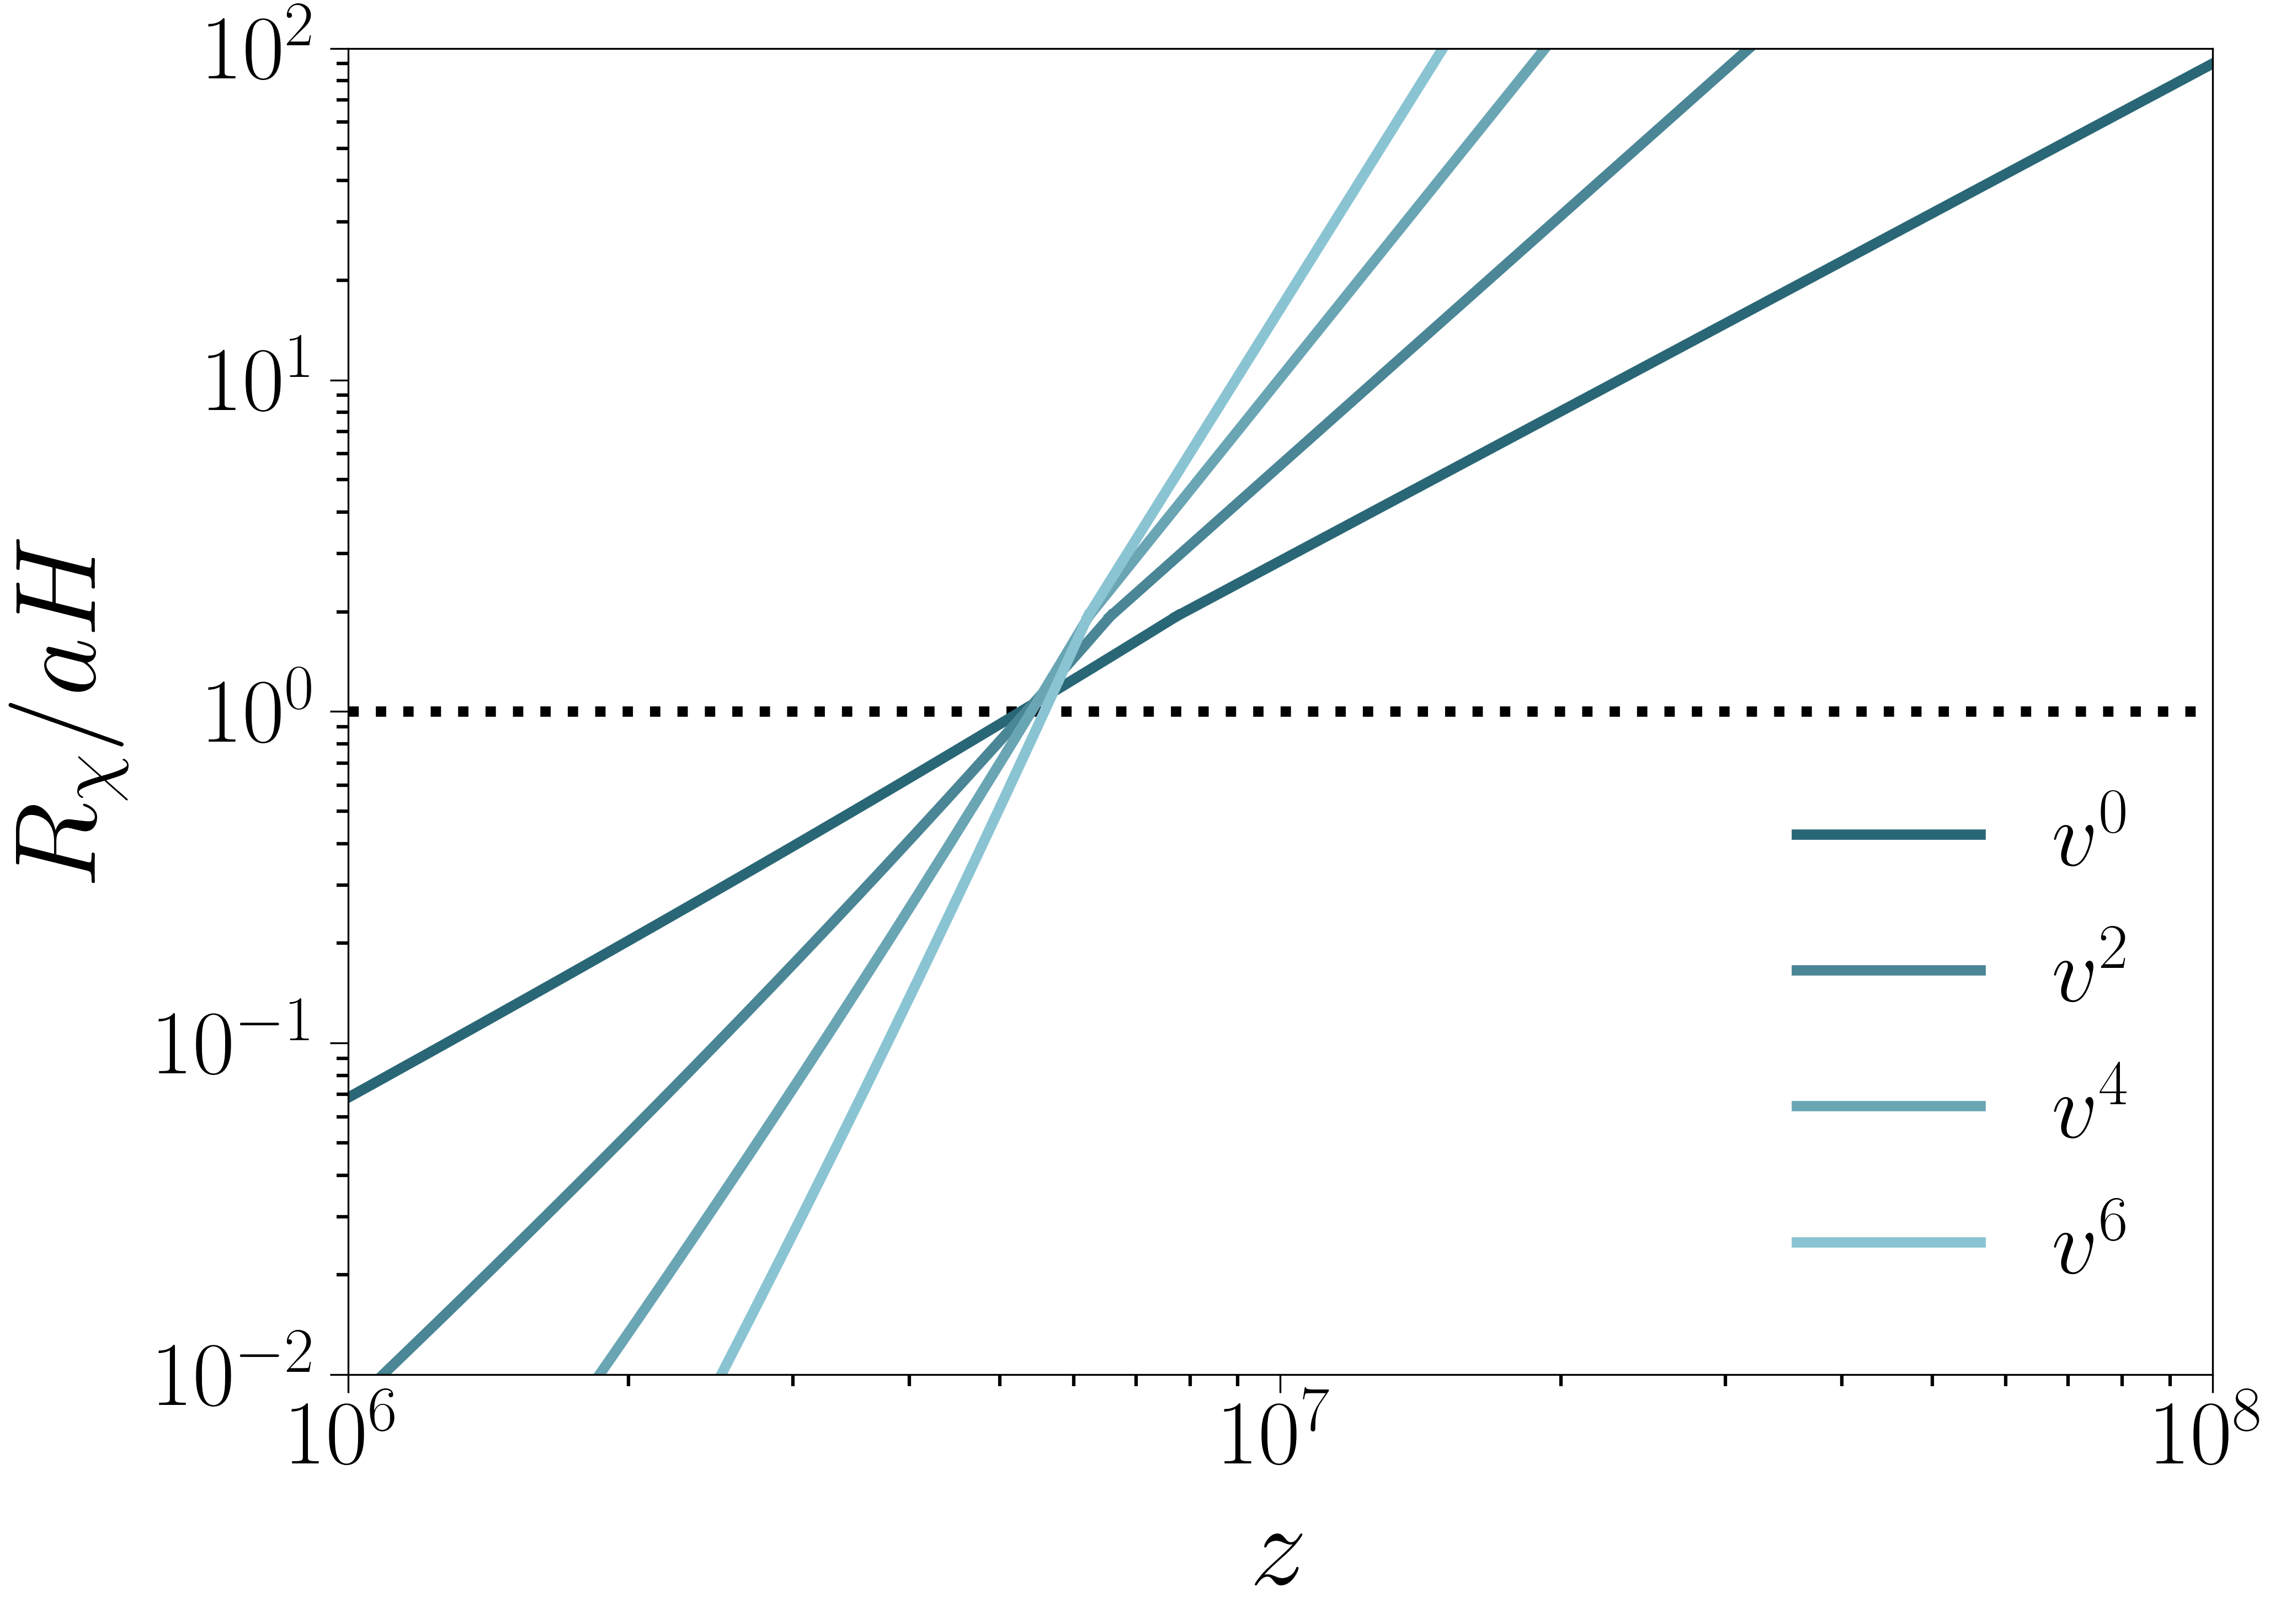

In [35]:
plt.figure(figsize=(14,10))

plt.axhline(1,c='k',ls=':',lw=4.5)
cm2 = LinearSegmentedColormap.from_list("mycmap", ['#8AC4D3','#205D6C'])

# n=0
n=0
s0=sigs0_anal[2]
zth = vds0.z_th(s0,1,n)
zkin = vds0.z_kin(s0,1,n)
zs1 = np.logspace(np.log10(zth),np.log10(1000.*zth),100)
zs2 = np.logspace(np.log10(zth/1000.),np.log10(zth),100)
plt.loglog(zs1,vds0.Rx_th(zs1,s0,1,n)/vds0.aH(zs1,s0,1,n),c=cm2(0.9),label=r'$v^{}$'.format(n),lw=4.5)
plt.loglog(zs2,vds0.Rx_kin(zs2,s0,1,n)/vds0.aH(zs2,s0,1,n),c=cm2(0.9),ls='-',lw=4.5)

n=2
s0=sigs2_anal[2]
zth = vds0.z_th(s0,1,n)
zkin = vds0.z_kin(s0,1,n)
zs1 = np.logspace(np.log10(zth),np.log10(1000.*zth),100)
zs2 = np.logspace(np.log10(zth/1000.),np.log10(zth),100)
plt.loglog(zs1,vds0.Rx_th(zs1,s0,1,n)/vds0.aH(zs1,s0,1,n),c=cm2(0.6),label=r'$v^{}$'.format(n),lw=4.5)
plt.loglog(zs2,vds0.Rx_kin(zs2,s0,1,n)/vds0.aH(zs2,s0,1,n),c=cm2(0.6),ls='-',lw=4.5)

n=4
s0=sigs4_anal[2]
zth = vds0.z_th(s0,1,n)
zkin = vds0.z_kin(s0,1,n)
zs1 = np.logspace(np.log10(zth),np.log10(1000.*zth),100)
zs2 = np.logspace(np.log10(zth/1000.),np.log10(zth),100)
plt.loglog(zs1,vds0.Rx_th(zs1,s0,1,n)/vds0.aH(zs1,s0,1,n),c=cm2(0.3),label=r'$v^4$',lw=4.5)
plt.loglog(zs2,vds0.Rx_kin(zs2,s0,1,n)/vds0.aH(zs2,s0,1,n),c=cm2(0.3),ls='-',lw=4.5)

n=6
s0=sigs6_anal[2]
zth = vds0.z_th(s0,1,n)
zkin = vds0.z_kin(s0,1,n)
zs1 = np.logspace(np.log10(zth),np.log10(1000.*zth),100)
zs2 = np.logspace(np.log10(zth/1000.),np.log10(zth),100)
plt.loglog(zs1,vds0.Rx_th(zs1,s0,1,n)/vds0.aH(zs1,s0,1,n),c=cm2(0),label=r'$v^6$',lw=4.5)
plt.loglog(zs2,vds0.Rx_kin(zs2,s0,1,n)/vds0.aH(zs2,s0,1,n),c=cm2(0),ls='-',lw=4.5)

plt.xlim(1e6,1e8)
plt.ylim(1e-2,1e2)
plt.xlabel(r'$z$',fontsize=50,labelpad=10)
plt.ylabel(r'$R_{\chi}/aH$',fontsize=50,labelpad=10)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.locator_params(axis='y', numticks=6)
plt.locator_params(axis='x', numticks=6)
plt.tick_params(length=8)
plt.tick_params(which='minor',length=5,width=1.5)

plt.legend(loc=4,fontsize=40,framealpha=0)
plt.tight_layout()
plt.savefig("Rx_aH.png")

---

---

---

# Other plots

NameError: name 'n4sigs2' is not defined

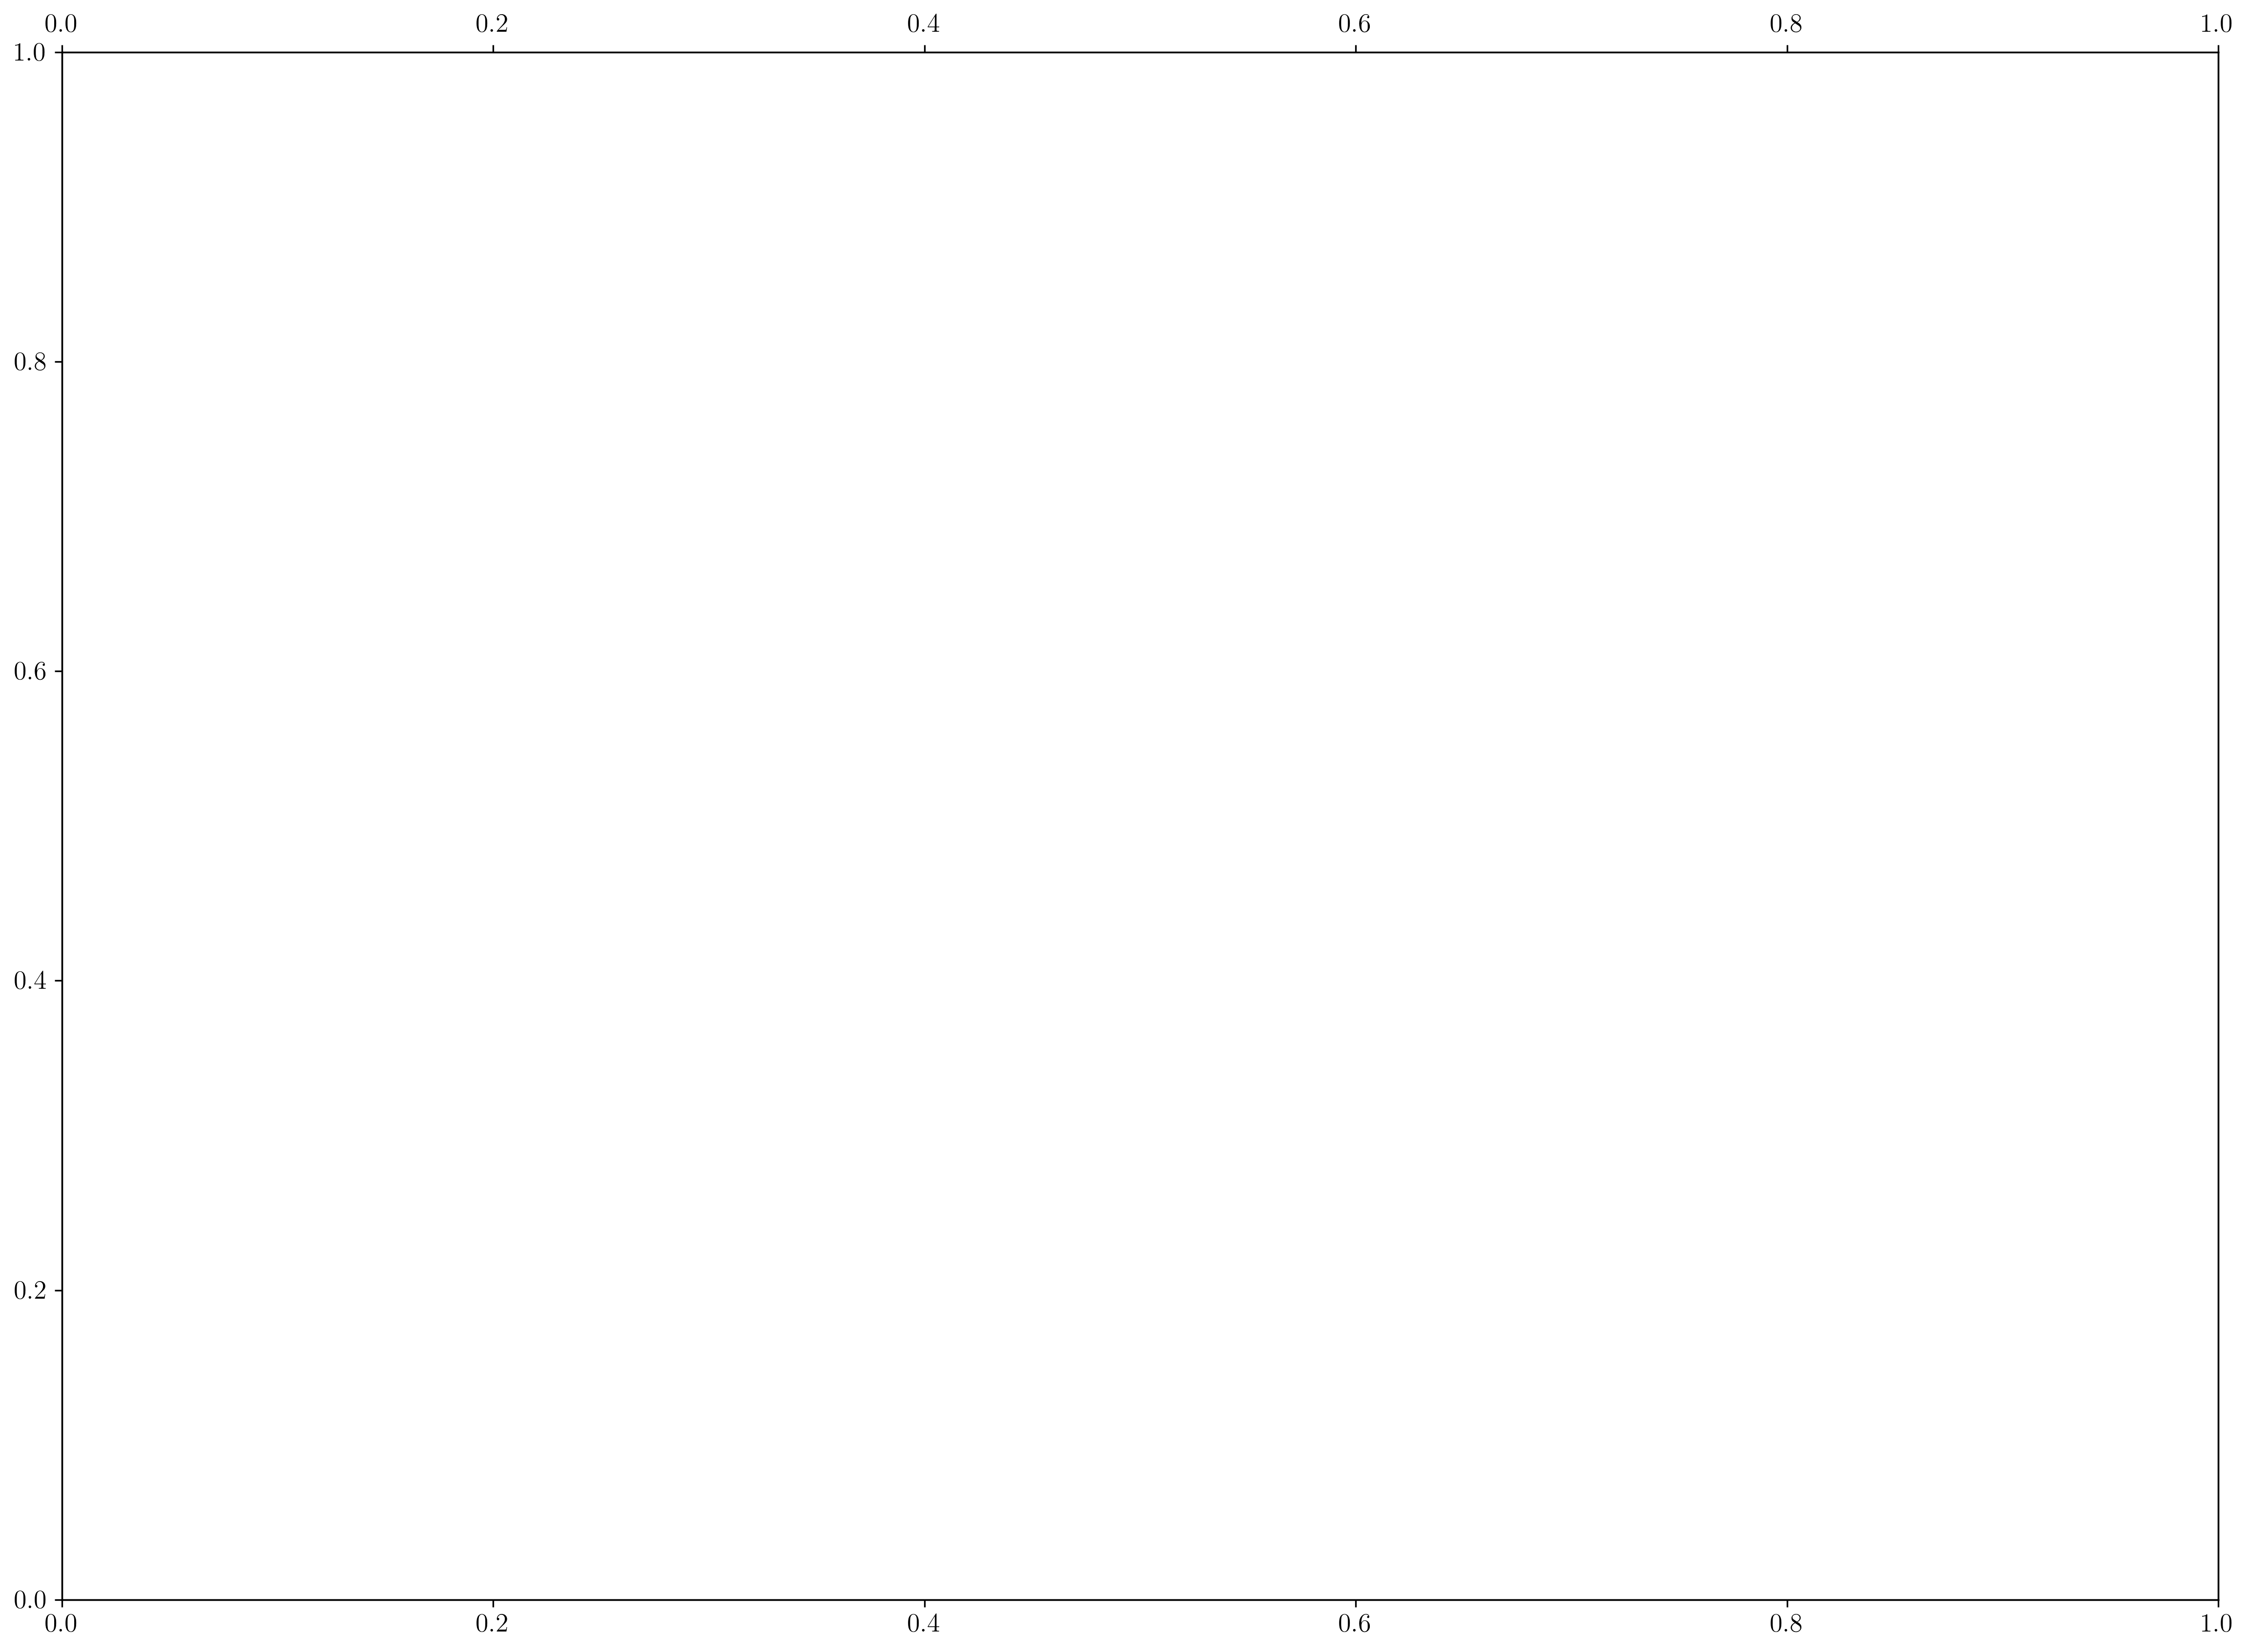

In [15]:
fig = plt.figure(figsize=(19,14))    
ax = fig.add_subplot(111)
ax2 = ax.twiny()

# vds0.all_sigmas(colorbar=True,npow=2,m=0.0001,sigmas=smallSigs,lw=6)
vds0.all_sigmas(colorbar=True,npow=4,m=0.01,sigmas=n4sigs2,lw=6)
# vds0.all_sigmas(colorbar=True,npow=6,m=0.0001,sigmas=smallSigs,lw=6)

ax.set_xscale('log')
ax.set_xlim(0.05,200)
ax.set_ylim(0.005,1.05)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T(k)_{IDM}$',fontsize=50,labelpad=10)
ax.set_xticks([0.1,1,10,30,50])
ax.set_xticklabels(["0.1","1","10","30","50"],fontsize=45)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)

ax2.set_xscale('log')
ax2.set_xlim(0.08,66)
ax2.set_xticks([vds0.mhm2khm(10**16),vds0.mhm2khm(10**14),vds0.mhm2khm(10**12),vds0.mhm2khm(10**10),vds0.mhm2khm(10**8)])
ax2.set_xticklabels([r'10$^{16}$',r'10$^{14}$',r'10$^{12}$',r'10$^{10}$',r'10$^{8}$'],fontsize=45)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=50,labelpad=20)
ax2.tick_params(length=15,width=3)

plt.text(0.105,0.88,"$n=4$\n$m=10$ MeV",fontsize=30,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
plt.tight_layout()
plt.savefig("plots/tk/tk_all_n2m100kev.png")

OSError: class/pk_output/n2_m1e-05_s1e-20_z1_pk.dat not found.

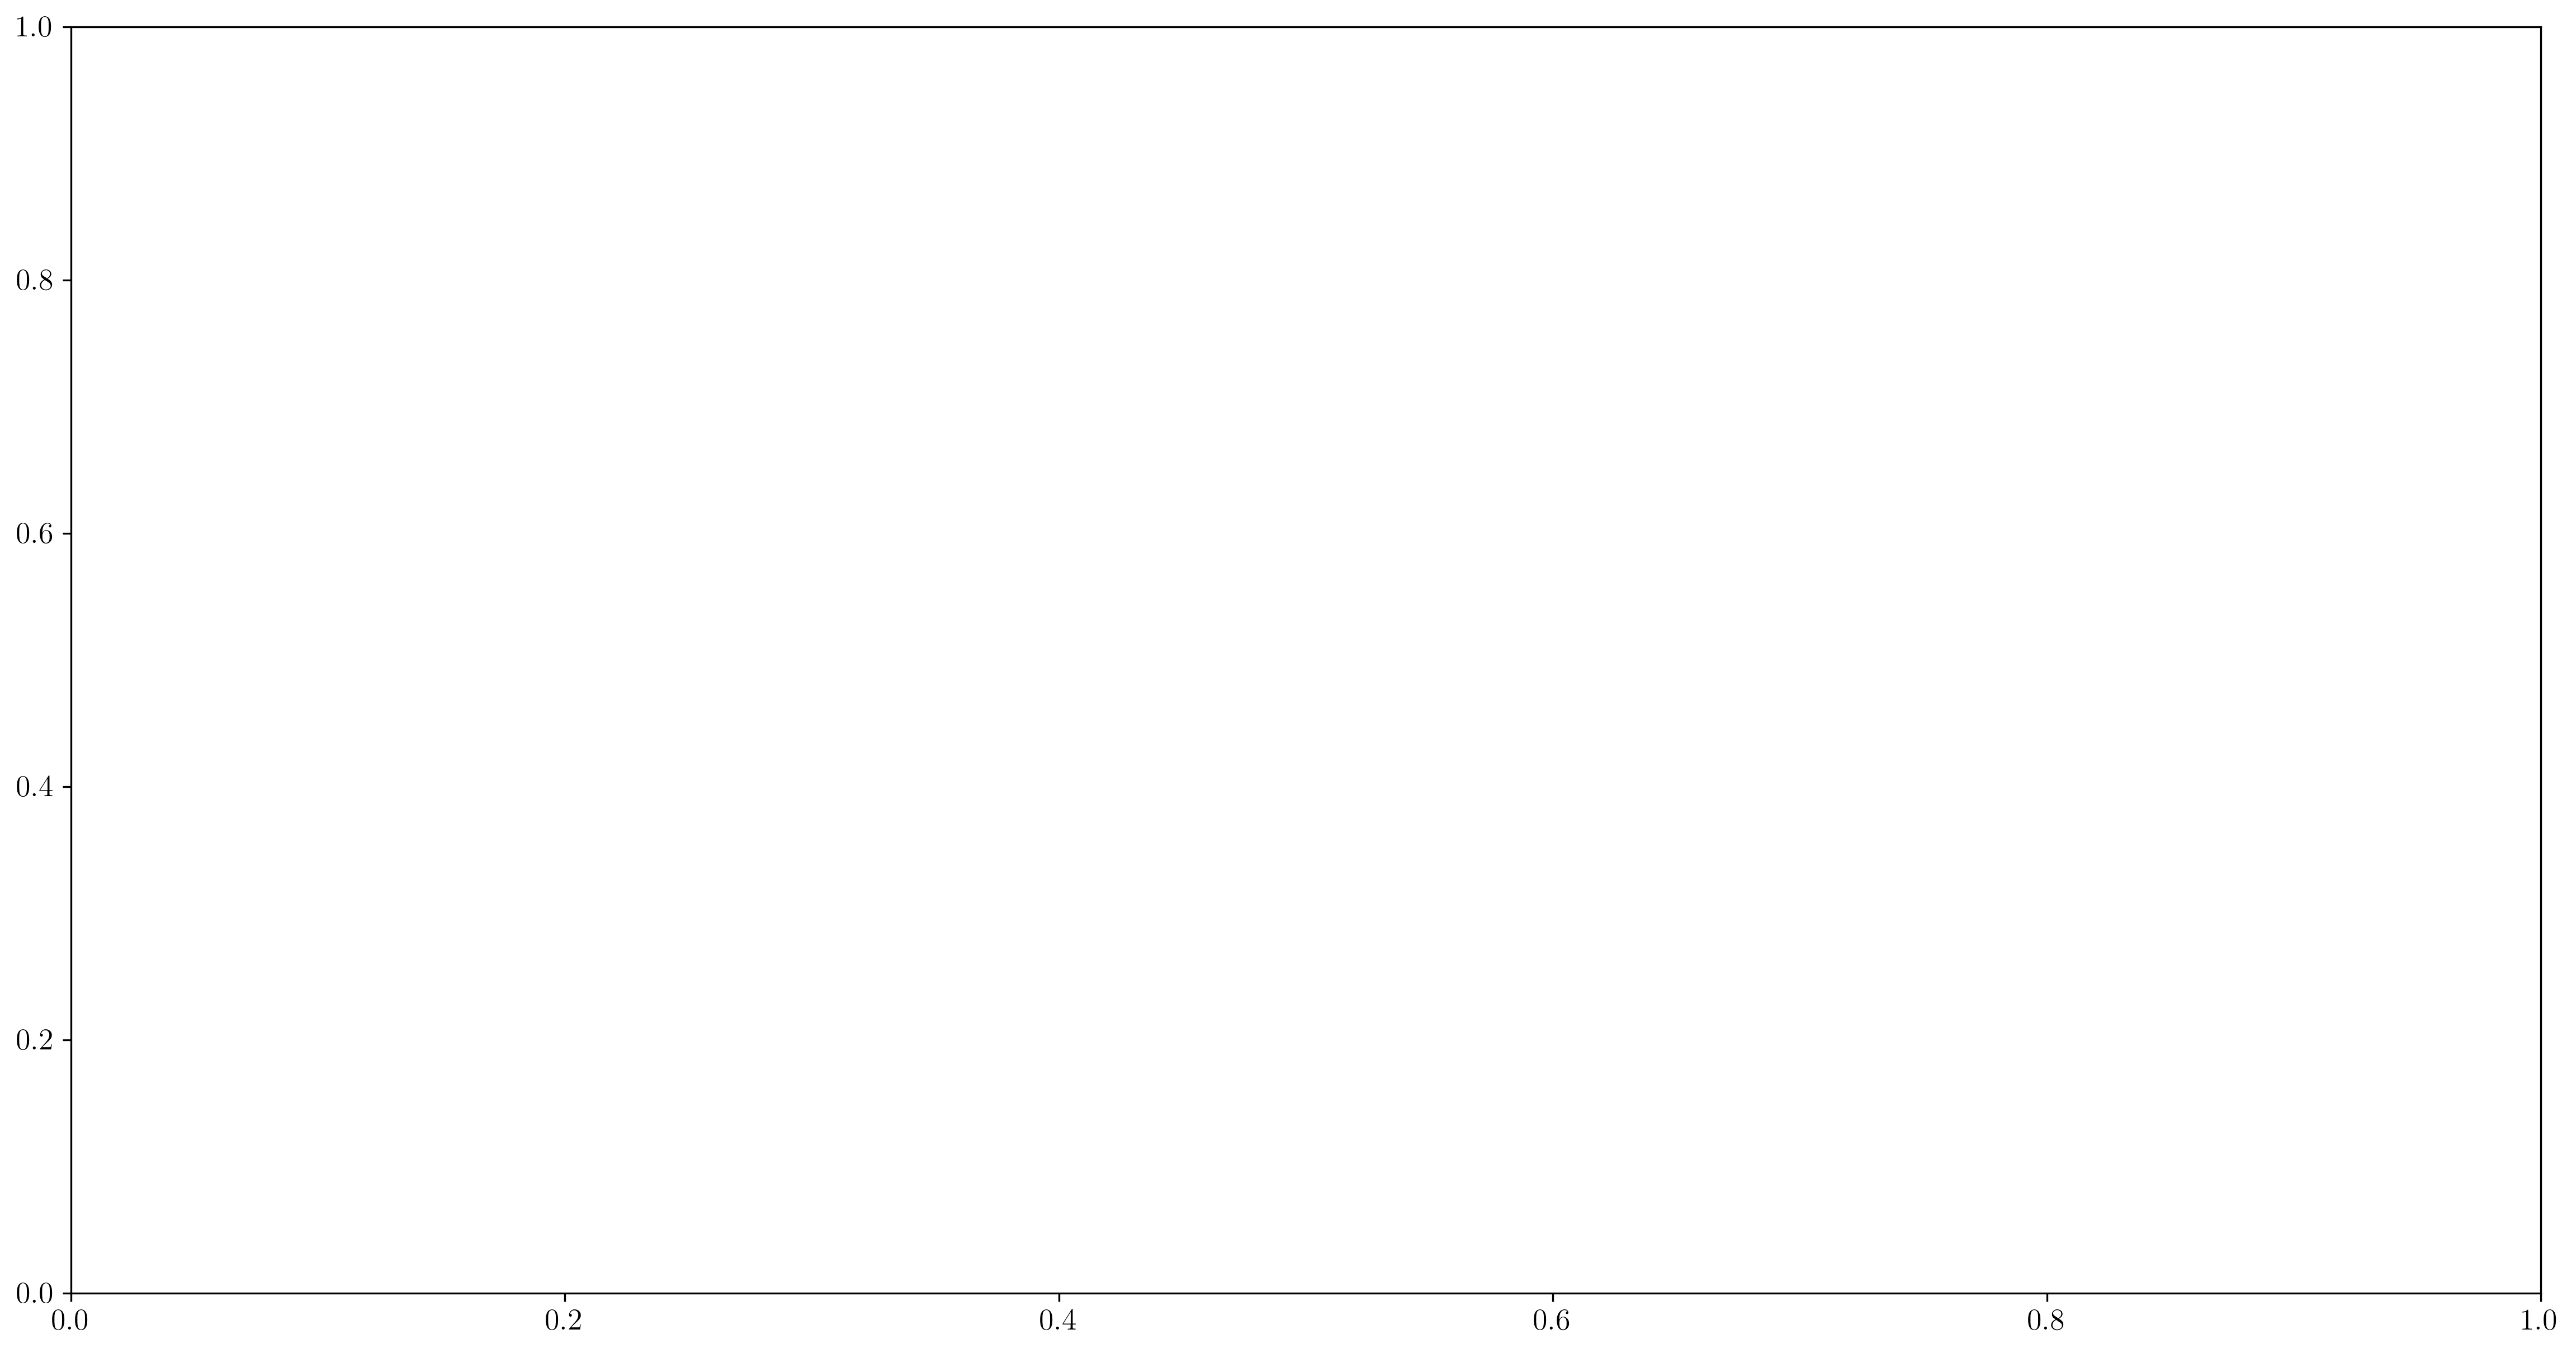

In [16]:
fig = plt.figure(figsize=(19,10))    
ax = fig.add_subplot(111)

vds0.all_masses(sigma=1e-20,colorbar=True,npow=2,lw=6)

ax.set_xscale('log')
ax.set_xlim(0.05,66)
ax.set_ylim(0.005,1.05)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T(k)_{IDM}$',fontsize=50,labelpad=10)
ax.set_xticks([0.1,1,10,30,50])
ax.set_xticklabels(["0.1","1","10","30","50"],fontsize=45)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)

plt.text(0.07,0.87,"$n=2$\n$\sigma_0=10^{-20}$ cm$^2$",fontsize=30,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
plt.tight_layout()
plt.savefig("plots/tk/tk_all_n2s1em20.png")

In [ ]:
fig = plt.figure(figsize=(14,10))    
ax = fig.add_subplot(111)
ax2 = ax.twiny()

mass = 0.0001
indx = 8
c1 = (math.sqrt((1+10.))/10,1-math.sqrt((1+10.))/10,1-math.sqrt((1+10.))/10)
c2 = (math.sqrt((1+40.))/10,1-math.sqrt((1+40.))/10,1-math.sqrt((1+40.))/10)
c3 = (math.sqrt((1+70.))/10,1-math.sqrt((1+70.))/10,1-math.sqrt((1+70.))/10)

tk_idm,ks,sigma0 = vds0.single_tk(label='$n=0$',npow=0,m=mass,c=c1,sigmas=smallSigs,index=indx,lw=5)
tk_idm,ks,sigma0 = vds0.single_tk(label='$n=2$',npow=2,m=mass,c=c2,sigmas=smallSigs,index=indx,lw=5)
tk_idm,ks,sigma0 = vds0.single_tk(label='$n=4$',npow=4,m=mass,c=c3,sigmas=smallSigs,index=indx,lw=5)
tk_idm,ks,sigma0 = vds0.single_tk(label='$n=6$',npow=6,m=mass,c='tan',sigmas=smallSigs,index=indx,lw=5)

ax.set_xscale('log')
ax.set_xlim(0.012,66)
ax.set_ylim(0.005,1.05)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T(k)_{IDM}$',fontsize=50,labelpad=10)
ax.set_xticks([0.1,1,10,30,50])
ax.set_xticklabels(["0.1","1","10","30","50"],fontsize=45)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)
ax.legend(fontsize=35,loc='upper left')

ax2.set_xscale('log')
ax2.set_xlim(0.08,66)
ax2.set_xticks([vds0.mhm2khm(10**16),vds0.mhm2khm(10**14),vds0.mhm2khm(10**12),vds0.mhm2khm(10**10),vds0.mhm2khm(10**8)])
ax2.set_xticklabels([r'10$^{16}$',r'10$^{14}$',r'10$^{12}$',r'10$^{10}$',r'10$^{8}$'],fontsize=35)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=40,labelpad=20)
ax2.tick_params(length=15,width=3)

plt.tight_layout()
plt.savefig("plots/exclusions/m100_nAll.png")